# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### NLP_02_model

Esta notebook se utiliza para:
- armar el modelo de estimación de tópicos
- validar resultados obtenidos
- guardar datos en los indices de opensearch

Esta y las consecuentes notebooks son el desarrollo de base de procesos y funciones para la web app provista.

### MODELO

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from datetime import datetime, date, timedelta
from dateutil.parser import parse
from dotenv import load_dotenv
from IPython.display import Image, display

from NLP_tools import *


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import init_opensearch, get_news, get_entities_news, get_title_news, update_news, get_pos_id
from opensearchpy import helpers

from openai import OpenAI

### Path

In [4]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [5]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Inicializamos la base vectorial

In [6]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Data de noticias original

In [7]:
# Cargar archivo previamente preprocesado en NLP_01_data 
choice = "20240716"   
df_parquet = pd.read_parquet(PATH+choice+".parquet").reset_index()
data = list(df_parquet['text'])
id_data = list(df_parquet['asset_id'])
title_data = list(df_parquet['title'])

In [8]:
# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

5975

### Preprocesar las noticias
Se realiza un preprocesamiento mínimo del texto, pero no se le quita el sentido semántico para que mediante SentenceTransformer se puedan capturar embeddings de mejor calidad.

In [9]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

In [10]:
clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 544.08it/s]


### Modelo

In [11]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(proc_data)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 2),
                vocabulary=['producción industrial', 'convivencia familiar',
                            'empleo registrado', 'SoD', 'Petronas',
                            'exposición directa', 'elementos', 'ingreso',
                            'Sergio Antonio Martínez', 'es indispensable',
                            'pequeñas empresas', 'La Fiscalía',
                            'Circuitos Turísticos', 'Atlético de Madrid',
                            'metros cuadrados', 'emociones', 'Sena',
                            'ataque cardíaco', 'tasa fija', 'Banco Macro',
                            'circo', 'futura enfermera', 'facha', 'liqui',
                            'Asunción de Paraguay', 'Salchicha de Vienal',
                            'dólar cripto', 'Estado nacional',
                            'plantel albiceleste', 'Von der Leyen', ...])

Capas del modelo BERTopic

In [12]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Datos de Entrenamiento a recuperar

In [13]:
# Cargar modelo entrenado o saltar celda y entrenar
#topic_model = BERTopic.load(PATH+f"modelos_notebook/bertopic_model_{choice}")
#topics = np.load(PATH+f"modelos_notebook/topics_{choice}.npy")
#probs = np.load(PATH+f"modelos_notebook/probs_{choice}.npy")

# Cargar los embeddings
#docs_embedding = np.load(PATH+f"modelos_notebook/docs_embeddings_{choice}.npy")

### Entrenamiento

In [14]:
# Entrenamiento
topics, probs = topic_model.fit_transform(proc_data)

2024-08-29 17:45:55,958 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 17:50:21,879 - BERTopic - Embedding - Completed ✓
2024-08-29 17:50:21,882 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-29 17:50:59,728 - BERTopic - Dimensionality - Completed ✓
2024-08-29 17:50:59,731 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-29 17:50:59,868 - BERTopic - Cluster - Completed ✓
2024-08-29 17:50:59,896 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-29 17:51:02,162 - BERTopic - Representation - Completed ✓


In [15]:
# Obtenemos embeddings de todos los documentos
docs_embedding = topic_model.embedding_model.embed(data)

### Datos de entrenamiento a guardar

In [16]:
# Grabar modelo
topic_model.save(PATH+f"modelos_notebook/bertopic_model_last")
#np.save(PATH+f"modelos_notebook/topics_{choice}.npy", topics)
#np.save(PATH+f"modelos_notebook/probs_{choice}.npy", probs)

# Guardar los embeddings en un archivo de NumPy
np.save(PATH+f"modelos_notebook/docs_embeddings_last.npy", docs_embedding)

2024-08-29 17:56:11,951 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## Grabar solo resultados del primer modelo en Topic y News
*** El segundo modelo corre en NLP_03_merged, para luego fusionar. ***

### Actualizar datos en news 

In [45]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding, topics, probs )

True

### Grabar todos los registros en Topic y la actualizacion en news

In [18]:
# Grabar todos los topicos en la base
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, topic_model, PATH)
        topic_entities_top  = top_entities(topic_id, topic_model, df_parquet)
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, topic_model, docs_embedding, id_data, title_data, data)
        

        topic_doc = Topic(
            index = topic_id,
            name =  get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client),
            vector = list(topic_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = datetime.now(),
            from_date = parse(date_choice),
            to_date = datetime.strptime(date_choice, '%Y-%m-%d') + timedelta(days=1),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()



## Resultados y operaciones con el modelo

In [19]:
print(f"Cantidad de tópicos {len(set(topic_model.topics_))} (incluye topico -1)")

Cantidad de tópicos 21 (incluye topico -1)


In [20]:
# Obtener documentos de cada tópico
topic_freq = topic_model.get_topic_freq()

# Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics = len(topic_freq)
print(f"Número de tópicos encontrados: {num_topics} (incluye el topico -1)")

# Imprimir la cant de documentos de cada tópico
print(topic_freq.to_string(index=False))

Número de tópicos encontrados: 21 (incluye el topico -1)
 Topic  Count
    -1    335
     0    156
     1     91
     2     70
     3     49
     4     32
     5     27
     6     25
     7     24
     8     23
     9     21
    10     18
    11     18
    12     18
    13     18
    14     13
    15     13
    16     13
    17     12
    18     12
    19     12


### Recuperar todos los topicos y sus etiquetas generadas por el modelo

In [21]:
topic_labels = topic_model.generate_topic_labels()
topic_labels

['-1_argentina_sociedades_2024',
 '0_víctima_penal_policía',
 '1_viviendas_pacto_ley',
 '2_actividades_cultura_turismo',
 '3_cuotas_categoría_multas',
 '4_show_cantante_fanáticos',
 '5_incendio_bomberos_incendios',
 '6_refuerzos_club_jugadores',
 '7_dólar_compra_brecha',
 '8_demencia_azúcar_salud',
 '9_temperatura_precipitaciones_temperaturas',
 '10_inteligencia_agencia_agencias',
 '11_soles_empleo_em',
 '12_periodistas_periodista_presidente',
 '13_millones_bancos_liquidez',
 '14_crecimiento_inflación_alza',
 '15_jugador_español_ciudad deportiva',
 '16_lesión_tobillo_selección',
 '17_juego_rompecabezas_batalla',
 '18_participantes_isla_inmunidad',
 '19_hs_música_piano']

### Buscar topicos ingresando un texto

In [22]:
topic_res = topic_model.find_topics("cambio climatico")
print(topic_res)
topic_labels[topic_res[0][np.argmax(topic_res[1])]+1]

([9, 14, 13, 8, 11], [0.5958034, 0.30266076, 0.25599703, 0.2507847, 0.24953091])


'9_temperatura_precipitaciones_temperaturas'

## Elegir un topico para pruebas

In [23]:
# Obtener los n documentos de un tópico
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

Topico N°: 14 --> 14_crecimiento_inflación_alza


### Buscar los titulos de los primeros n documentos de un topico

In [24]:
n_docs = 5  # N documentos a recuperar
topic_docs_idx = [i for i, (doc, topic) in enumerate(zip(list(df_parquet['title']), topic_model.topics_)) if topic == topic_id]
n_docs = n_docs if n_docs <= len(topic_docs_idx) else len(topic_docs_idx)

print(f"{n_docs} de {len(topic_docs_idx)} titulos de noticias encontrados en el tópico {topic_id:}")
for idx in topic_docs_idx[:n_docs]:
    print("- ",df_parquet.iloc[idx]['title'])

5 de 13 titulos de noticias encontrados en el tópico 14
-  El FMI pronostica una recesión más profunda en Argentina para 2024
-  Se pronostica que la recesión económica del país será más fuerte a fin de año
-  El FMI advierte una profundización de la contracción económica en Argentina y proyecta que el PBI caerá 3,5% este año
-  El FMI empeoró las previsiones sobre la caída de la economía argentina en 2024
-  FMI recorta previsiones económicas para Argentina: Se espera una caída más pronunciada


#### Busqueda de documentos por topico, ordenados por mayor probabilidad

In [25]:
docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic_id]
score_docs = topic_model.probabilities_[docs_per_topics]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

reg_data = []
for i, doc in enumerate(docs_per_topics):
    reg_data.append([df_parquet.iloc[doc].asset_id, df_parquet.iloc[doc].title, round(score_docs[i],4)])

df_query = pd.DataFrame(reg_data, columns=['ID','titulo','score'])
print(len(df_query), "docs encontrados")
df_query.sort_values('score', ascending=False).style.set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 14 --> 14_crecimiento_inflación_alza
13 docs encontrados


,ID,titulo,score
0,114863267,El FMI pronostica una recesión más profunda en Argentina para 2024,1.000000
1,114880736,Se pronostica que la recesión económica del país será más fuerte a fin de año,1.000000
2,114836975,"El FMI advierte una profundización de la contracción económica en Argentina y proyecta que el PBI caerá 3,5% este año",1.000000
3,114837382,El FMI empeoró las previsiones sobre la caída de la economía argentina en 2024,1.000000
4,114846527,FMI recorta previsiones económicas para Argentina: Se espera una caída más pronunciada,1.000000
6,114850984,El FMI prevé que la actividad en Argentina caiga más de lo esperado y subió el riesgo país,1.000000
8,114847003,"El FMI estimó que el PBI en Argentina caerá 3,5%",1.000000
10,114839206,El FMI se corrige y proyecta que la recesión argentina será peor,1.000000
11,114847513,El FMI pide diálogo político en Argentina tras revisar al alza su contracción para 2024,1.000000
12,114805524,Argentina tiene la nafta más cara de la región,1.000000


### Criterio de corte (umbral)
El criterio de corte utilizado para filtrar las noticias que pertenecen a un topico es la "media"

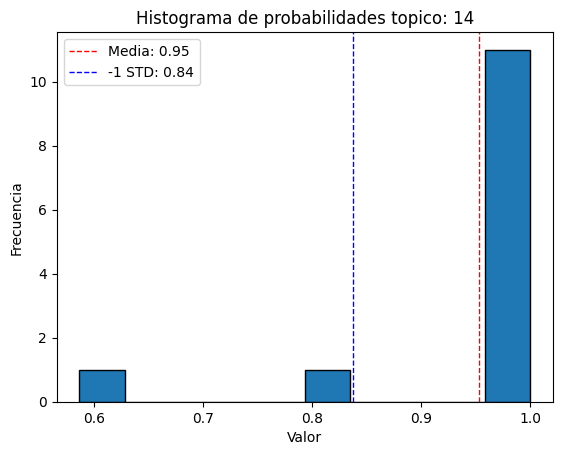

In [26]:
# Calcular la media, el desvío estándar

mean = np.mean([fila[2] for fila in reg_data])
std_dev = np.std([fila[2] for fila in reg_data])

# Crear el histograma
plt.hist([fila[2] for fila in reg_data], bins=10, edgecolor='black')

# Añadir líneas para la media, la moda y el desvío estándar
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Media: {mean:.2f}')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label=f'-1 STD: {mean - std_dev:.2f}')


# Añadir títulos y etiquetas
plt.title(f'Histograma de probabilidades topico: {topic_id}')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [27]:
# Definir la función de estilo
def color_rows(row, label, value):
    if row[label] >= value:
        return ['color: cyan'] * len(row)
    else:
        return [''] * len(row)

# Calcular la media
threshold = df_query.score.mean()

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(f"Umbral de corte {threshold}")

df_query.sort_values('score', ascending=False, inplace=True)
df_query.style.apply(lambda row: color_rows(row, 'score', threshold), axis=1).set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 14 --> 14_crecimiento_inflación_alza
Umbral de corte 0.9524538461538463


,ID,titulo,score
0,114863267,El FMI pronostica una recesión más profunda en Argentina para 2024,1.000000
1,114880736,Se pronostica que la recesión económica del país será más fuerte a fin de año,1.000000
2,114836975,"El FMI advierte una profundización de la contracción económica en Argentina y proyecta que el PBI caerá 3,5% este año",1.000000
3,114837382,El FMI empeoró las previsiones sobre la caída de la economía argentina en 2024,1.000000
4,114846527,FMI recorta previsiones económicas para Argentina: Se espera una caída más pronunciada,1.000000
6,114850984,El FMI prevé que la actividad en Argentina caiga más de lo esperado y subió el riesgo país,1.000000
8,114847003,"El FMI estimó que el PBI en Argentina caerá 3,5%",1.000000
10,114839206,El FMI se corrige y proyecta que la recesión argentina será peor,1.000000
11,114847513,El FMI pide diálogo político en Argentina tras revisar al alza su contracción para 2024,1.000000
12,114805524,Argentina tiene la nafta más cara de la región,1.000000


#### Documentos mas representativos de un topico

- [1]  Desde el metodo del modelo

In [28]:
docs_representative = topic_model.get_representative_docs(topic=topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
docs_representative

Topico N°: 14 --> 14_crecimiento_inflación_alza


['El Fondo Monetario Internacional FMI pidió este martes diálogo político en Argentina a la vez que siguió apoyando las medidas de su presidente Javier Milei tras aumentar en siete décimas su perspectiva al 3 5 % para 2024 Por primera vez en mucho mucho el Gobierno ha entregado un presupuesto equilibrado La pregunta es si puede continuar haciéndolo en el futuro y ahí es donde la colaboración con el Parlamento será muy importante afirmó el economista jefe del FMI Pierre Olivier Gourinchas Gourinchas habló durante una rueda de prensa en Washington para presentar el último informe de perspectivas de crecimiento WEO por sus siglas en inglés del Fondo En ese documento el Fondo prevé que el Producto Interior Bruto PIB argentino tenga una contracción del 3 5 % una revisión al alza de siete décimas respecto a su informe de abril En cambio para 2025 la economía argentina crecerá un 5 % el Fondo Gourinchas destacó una importante reducción en la inflación para 2024 que ahora el FMI proyecta en el

- [2] Por similitud coseno del topico a los tres documento mas cercanos

In [29]:
# Obtenemos la matriz de similitud coseno entre topicos y documentos
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, docs_embedding)
sim_matrix.shape

(21, 1000)

In [30]:
# Similitud coseno entre el topico y los documentos del topico elegido
s_coseno = []
for i in docs_per_topics:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic_id + 1]], [docs_embedding[i]])[0][0])

# Indices
idx_coseno_sort = np.argsort(s_coseno)[::-1]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

for idx in idx_coseno_sort[:3]:
    print(idx, df_parquet.iloc[docs_per_topics[idx]].title)


Topico N°: 14 --> 14_crecimiento_inflación_alza
0 El FMI pronostica una recesión más profunda en Argentina para 2024
3 El FMI empeoró las previsiones sobre la caída de la economía argentina en 2024
2 El FMI advierte una profundización de la contracción económica en Argentina y proyecta que el PBI caerá 3,5% este año


- [3] Primer documento mas cercano al embedding del topico

In [31]:
# Documento de maxima similitud con el topico

simil_docs_topic = sim_matrix[topic_id+ 1].argmax()
print(f"Noticia de maxima similitud con el topico: {topic_id}")
print(f"Doc ID: {df_parquet.index[simil_docs_topic]}")
print(f"Titulo: {df_parquet.iloc[simil_docs_topic].title}")
best_doc = data[simil_docs_topic]

Noticia de maxima similitud con el topico: 14
Doc ID: 21
Titulo: El FMI pronostica una recesión más profunda en Argentina para 2024


#### Keywords de un topico (modelo)

In [32]:
# Obtener las palabras clave para un topico dado
topic_keywords = topic_model.get_topic(topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(topic_keywords)

Topico N°: 14 --> 14_crecimiento_inflación_alza
[('crecimiento', 0.08564659922318589), ('inflación', 0.07257360969676652), ('alza', 0.06561274746900343), ('repunte', 0.059639319456269144), ('contracción', 0.056569679356042374), ('abril', 0.05215634029860844), ('economía', 0.05097464141750148), ('argentina', 0.04884041373880224), ('gasto', 0.047385178781607876), ('reporte', 0.04510765450471674)]


#### Keywords de un topico (otra forma de obtenerlos)

In [33]:
keywords = topic_model.topic_representations_[topic_id]
topic_keywords = [TopicKeyword(name=keyword, score=score) for keyword, score in keywords if keyword != '']
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
topic_keywords

Topico N°: 14 --> 14_crecimiento_inflación_alza


[{'name': 'crecimiento', 'score': 0.08564659922318589},
 {'name': 'inflación', 'score': 0.07257360969676652},
 {'name': 'alza', 'score': 0.06561274746900343},
 {'name': 'repunte', 'score': 0.059639319456269144},
 {'name': 'contracción', 'score': 0.056569679356042374},
 {'name': 'abril', 'score': 0.05215634029860844},
 {'name': 'economía', 'score': 0.05097464141750148},
 {'name': 'argentina', 'score': 0.04884041373880224},
 {'name': 'gasto', 'score': 0.047385178781607876},
 {'name': 'reporte', 'score': 0.04510765450471674}]

### Top keywords de un topico

In [34]:
# Calculo de umbral de corte para las keywords
def keywords_umbral(topic_keywords):
    freq_k = []
    for name_score in topic_keywords:
        freq_k.append(name_score['score'])
    umbral_k = np.array(freq_k).mean()
    print(f"umbral keywords: {umbral_k}")

    topic_keywords_top = {}
    for name_score in topic_keywords:
        if name_score['score'] >= umbral_k:
            topic_keywords_top[name_score['name']] = name_score['score']

    return topic_keywords_top

keywords_umbral(topic_keywords)

umbral keywords: 0.05845061839425042


{'crecimiento': 0.08564659922318589,
 'inflación': 0.07257360969676652,
 'alza': 0.06561274746900343,
 'repunte': 0.059639319456269144}

### Top Entities de un topico

In [35]:
threshold = df_query.score.mean()
print(f"umbral entities: {threshold}")

entities_topic = []
for doc_ID in list(df_query[df_query["score"] > threshold]['ID']):
    entities_topic.append(get_entities_news(doc_ID))

# Crear un diccionario para contar en cuántos documentos aparece cada palabra
document_frequencies = defaultdict(int)

# Crear un conjunto para cada documento y contar las palabras únicas
for lista in entities_topic:
    unique_words = set(lista)
    for palabra in unique_words:
        document_frequencies[palabra] += 1

# Ordenar las palabras por la frecuencia de documentos de mayor a menor
sorted_frequencies = sorted(document_frequencies.items(), key=lambda item: item[1], reverse=True)

# Calcular el umbral
freq_e = [item[1] for item in sorted_frequencies]
umbral_e = np.mean(freq_e)

# Obtener el resultado ordenado de las primeras 10 entidades segun criterio de corte
topic_entities_top = {}
c=0
for idx in range(len(sorted_frequencies)):
    if sorted_frequencies[idx][1] >= umbral_e:
        if c != 10:
            topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]
        else:
            break
        c += 1 

    elif len(topic_entities_top) <= 3:
        topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]

topic_entities_top



umbral entities: 0.9524538461538463


{'Brasil': 7,
 'FMI': 6,
 'la Argentina': 6,
 'Fondo Monetario Internacional': 5,
 'Argentina': 3,
 'WEO': 3,
 'México': 3,
 'Javier Milei': 2,
 'Manuel Adorni': 2,
 'Perspectivas': 2}

### Obtener los titulos de noticias del topico filtrado por umbral de corte 

In [36]:
topic_documents_title, threshold = topic_documents(topic_id, topic_model, df_parquet)
print(threshold)
topic_documents_title

0.9524538461538463


['El FMI pronostica una recesión más profunda en Argentina para 2024',
 'Se pronostica que la recesión económica del país será más fuerte a fin de año',
 'El FMI advierte una profundización de la contracción económica en Argentina y proyecta que el PBI caerá 3,5% este año',
 'El FMI empeoró las previsiones sobre la caída de la economía argentina en 2024',
 'FMI recorta previsiones económicas para Argentina: Se espera una caída más pronunciada',
 'El FMI prevé que la actividad en Argentina caiga más de lo esperado y subió el riesgo país',
 'El FMI estimó que el PBI en Argentina caerá 3,5%',
 'El FMI se corrige y proyecta que la recesión argentina será peor',
 'El FMI pide diálogo político en Argentina tras revisar al alza su contracción para 2024',
 'Argentina tiene la nafta más cara de la región',
 'Proponen fijar la cantidad máxima de empleados por cada legislador']

### Generar un nombre de topico con LLM ( Open AI)
- Validar OPENAI_API_KEY en .env

In [37]:
for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)        
        print(f"{topic_id} {get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client)}")

0 Violencia y justicia en Argentina
1 Diálogo entre Gobierno y CGT
2 Actividades culturales y recreativas invernales
3 Cambios en regulaciones y tarifas.
4 Accidentes y polémicas en espectáculos
5 Incendios forestales en Córdoba
6 Escándalo por refuerzos de Boca
7 Cotización del dólar blue hoy
8 Consejos de cocina y salud.
9 Pronóstico del clima en Argentina
10 Disolución y reestructuración de inteligencia.
11 Crisis económica en América Latina
12 Relaciones políticas y seguridad presidencial
13 Riesgo financiero y deuda argentina
14 Pronóstico de recesión en Argentina
15 Presentación de Kylian Mbappé en Madrid
16 Recepción de la Selección Argentina
17 Temas variados de actualidad.
18 Reality show de supervivencia extrema
19 Actividades culturales y eventos destacados


### Recuperar todos los topicos desde el indice Topic de la base

In [38]:
index_name = 'topic'

topics_list = []
for i, doc in enumerate(Topic.search().query().scan()):
    topics_list.append(doc.to_dict())
    print(topics_list[i]['index'], topics_list[i]['name'])

0 Violencia y justicia en la sociedad
1 Diálogo entre Gobierno y CGT
2 Actividades culturales y recreativas invernales
3 Cambios en regulaciones y tarifas
4 Accidentes y polémicas en espectáculos
5 Incendios forestales en Córdoba
6 Escándalo por refuerzos de Boca
7 Cotización del dólar blue hoy
8 Consejos de cocina y salud.
9 Pronóstico del clima en Argentina
10 Disolución y reestructuración de inteligencia.
11 Crisis económica en América Latina
12 Relaciones políticas y seguridad presidencial
13 Riesgos económicos en Argentina
14 Pronóstico de recesión en Argentina
15 Presentación de Kylian Mbappé
16 Recepción de la Selección Argentina
17 Temas diversos de actualidad.
18 Reality show de supervivencia extrema
19 Actividades culturales y eventos destacados


### Busqueda de 5 documentos del indice news de la base correspondiente a un topico
** (devuelve los docs que han sido marcados en el campo process en True )

In [39]:
topic_id = np.random.randint(len(set(topic_model.topics_))-1) # Obtener un topico al azar
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

Topico N°: 12 --> Relaciones políticas y seguridad presidencial


In [40]:
topic_embedding = topics_list[topic_id]['vector']

index_name = 'news'
# Crear una consulta KNN para buscar embeddings cercanos
knn_query = {
    "size": 5,  # Número de resultados que deseas obtener
    "query": {
        "bool": {
            "must": [
                {
                    "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 10  # Número de vecinos más cercanos
                        }
                    }
                },
                {
                    "term": {
                        "process": True  # Solo incluir documentos donde 'process' es True
                    }
                }
            ],
            "filter": {
                "exists": {
                    "field": "vector"  # Solo incluir documentos que tienen el campo 'vector'
                }
            }
        }
    }
}
# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
print(f"Topico N°: {topic_id} --> {topics_list[topic_id]['name']}" )

if response_topic['hits']['total']['value'] > 0:
    for i in [hit['_source']['title'] for hit in response_topic['hits']['hits']]:
        print(i)
else:
    print("No se encontraron documentos cercanos al topico dado.")

Topico N°: 12 --> Relaciones políticas y seguridad presidencial
Custodias presidenciales: piden revisar los protocolos por la "discrecionalidad" que tienen los funcionarios
Increíble: ahora Manuel Adorni asegura que no les preocupa el valor del dólar ni el riesgo país
El Gobierno no reforzará la seguridad del presidente Milei tras el atentado contra Trump
Donald Trump reapareció con la oreja vendada en la Convención Republicana
Rosendo Fraga: "Para Milei es más importante Elon Musk que Trump"


### Nuevo documento consultando embeddings generados por el modelo

In [41]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)
sim_matrix_new = cosine_similarity(topic_model.topic_embeddings_, new_doc_embedding.reshape(1, -1))

idx = np.argmax(sim_matrix_new)-1         # Topicos desde -1, 0, 1, ..., n
print(f"Topico N°: {topics_list[idx]['index']} --> {topics_list[idx]['name']}" )

Topico N°: 0 --> Violencia y justicia en la sociedad


### Nuevo documento consultando embeddings de la base

In [42]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)

# Buscamos en la base a que topico pertenece el nuevo documento
knn_query = {
    "size": 1,
    "query": {
        "knn": {
            "vector": {
                "vector": new_doc_embedding,
                "k" : 3
            }
        }
    }
}
response = os_client.search(index='topic', body=knn_query)

if response['hits']['total']['value'] > 0:
    print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
    print(f"Estimacion: {response['hits']['hits'][0]['_score']}")
else:
    print(f"Topico no encontrado")

Topico: Violencia y justicia en la sociedad
Estimacion: 0.7237131


### Graficar los topicos en 3d

In [43]:
import plotly.express as px

# Obtener los embeddings de los tópicos
topic_embeddings = topic_model.topic_embeddings_

new_doc = "Fuga de presos en San Telmo"  # nuevo texto
new_doc_embedding = topic_model.embedding_model.embed([new_doc])[0] # embedding de nuevo texto

total = np.vstack((topic_embeddings, new_doc_embedding))

# Reducir la dimensionalidad de los embeddings a 3D usando UMAP
umap_model = UMAP(n_components=3)
embeddings_3d = umap_model.fit_transform(total)

# Obtener las etiquetas de los tópicos
topics_labels = [str(i)+" "+name['name'][:50] for i, name in enumerate(topics_list) ]

# Crear un DataFrame para Plotly
df_plotly = pd.DataFrame(embeddings_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_plotly['Topico'] = ["-1"] + topics_labels + ['>>'+new_doc[:15]] # Identificamos el nuevo documento
df_plotly['Etiqueta'] = list(range(-1, len(topic_embeddings)-1)) + [new_doc[:15]]

# Graficar los tópicos en 3D de manera interactiva usando Plotly, ajustando el tamaño del gráfico
fig = px.scatter_3d(df_plotly, x='Dim1', y='Dim2', z='Dim3', color='Topico', text='Etiqueta', title='Visualización 3D de Tópicos con BERTopic')


# Ajustar el tamaño del gráfico
fig.update_layout(
    autosize=False,
    width=1200,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    margin=dict(l=65, r=50, b=65, t=90)
)

# Mostrar el gráfico
fig.show()

### Resumen

Luego de correr esta notebook se puede observar en elastivue los topicos generados

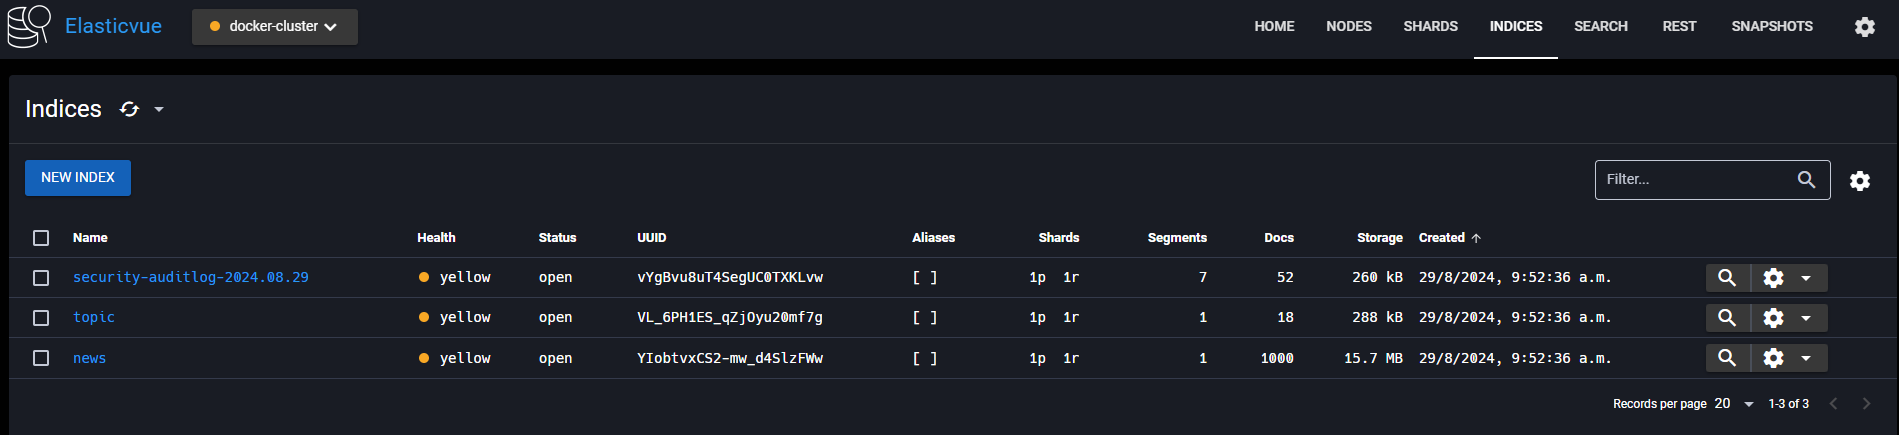

In [44]:
display(Image(filename=r'C:\Users\gabri\OneDrive\Machine Learning\Github\ITBA-NLP\images\elastivue_1.png'))